In [2]:
import cv2 
import numpy as np
import string
import random
import glob

import imgaug.augmenters as iaa

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
bg_pattern = glob.glob(r"pattern/*.*")
random.shuffle(bg_pattern)

# Augmentation settings for  Anchor, Positive, Negative

In [4]:
sometimes = lambda aug: iaa.Sometimes(0.3, aug)
sometimes2 = lambda aug: iaa.Sometimes(0.1, aug)
    
seq_a = iaa.Sequential([
            iaa.GaussianBlur(sigma=(0.5, 1.5)),
        ])
            
seq_p_n = iaa.Sequential([
        iaa.Crop(px=(2, 20), keep_size=True),
        #iaa.Fliplr(0.5),
        iaa.GaussianBlur(sigma=(0, 1.5)),
        sometimes(iaa.Affine(
                scale={"x": (0.95, 1.1), "y": (0.95, 1.05)}, 
                translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}, 
                rotate=(-2, 2),
                cval=(0, 255) 
               
            )),
        sometimes(iaa.FastSnowyLandscape(lightness_threshold=(10, 30))),
        sometimes(iaa.Snowflakes(density=(0.002, 0.004))),
        sometimes(iaa.AddToHueAndSaturation((-5, 5)))
])

In [5]:
def random_generator(size=6, chars=string.ascii_uppercase + string.digits + " "):
    """
    generate a random text
    @size the number of generated characters
    @chars the allowed list of characters to generate from
    
    output a generated string
    """
    return ''.join(random.choice(chars) for x in range(size))

def get_enlarged_p_n(img_size, input_rect, ratio = 0.2):
    """
    enlarge the input_rect by ratio and shouldn't exceed the img_size limits
    @img_size (width, height)
    @input_rect [x0, y0, x1, y1]
    
    output the enlarged new_rect by ratio
    """
    new_rect = input_rect[:]
    w_ratio = int((new_rect[2] - new_rect[0]) * ratio)
    h_ratio = int((new_rect[3] - new_rect[1]) * ratio)
    if new_rect[0] - w_ratio < 0:
        new_rect[0] = 0
    else:
        new_rect[0] = new_rect[0] - w_ratio
    
    if new_rect[2] + w_ratio > img_size[0]:
        new_rect[2] = img_size[0]
    else:
        new_rect[2] = new_rect[2] + w_ratio
        
    if new_rect[1] - h_ratio < 0:
        new_rect[1] = 0
    else:
        new_rect[1] = new_rect[1] - h_ratio
        
    if new_rect[3] + h_ratio > img_size[1]:
        new_rect[3] = img_size[1]
    else:
        new_rect[3] = new_rect[3] + h_ratio
    
    return new_rect

def compute_new_size_by_min_dim(input_size, min_threshold_dim = 80):
    '''
    upscale the minimum dimension of input_size to min_threshold_dim if its value is less and upscale the other dimension 
    based on this ratio
    return the new size
    '''
    new_size = input_size[:]
    min_size = min(input_size[0], input_size[1])
    if min_size == new_size[0]: # width
        new_size[0] = min_threshold_dim
        new_size[1] = int((min_threshold_dim/input_size[0]) * input_size[1])
    else:
        new_size[0] = int((min_threshold_dim/input_size[1]) * input_size[0])
        new_size[1] = min_threshold_dim
    return new_size  #width, height

def get_random_bg():
    """
    Generate a random solid background / or get a random image from patterns folder 
    """
    img = []
    if random.random() > 0.6:
        img_path = random.choice(bg_pattern)
        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (1000, 400))
    else:
        img = np.zeros((400, 1000, 3), np.uint8)
        img[:] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return img.copy()

In [6]:
def generate_batch_of_triplets(batch_size=8):
    """
    generate a batch of triplets where anchor and positive have the same text, while negative have a different text.
    @batch_size the number of triplets to generate
    
    output triplets [a][p][n], each one have the shape (batch_size, height, width, channels)
    """
    # choose length for the batch
    length = random.randint(2, 20)
    
    random_b_str = random_generator(length)
    font_b = random.randint(0, 7)
    fontScale_b = random.uniform(0.9, 2.0)
    thickness_b = random.randint(1, 4)
    textsize_batch_area = cv2.getTextSize(random_b_str, font_b, fontScale_b, thickness_b)[0]
    batch_img_size = (textsize_batch_area[0]+20, textsize_batch_area[1]+20) # add padding 10 from all sides - so (20 to width, 20 to height)
    b_width, b_heigth = batch_img_size[0], batch_img_size[1]
    b_width, b_heigth = compute_new_size_by_min_dim([b_width, b_heigth])
    
    triplets=[np.zeros((batch_size, b_heigth, b_width, 3), dtype=np.uint8) for i in range(3)]
    triplets_txt=[[],[],[]]
    for b in range(batch_size):
        # choose background
        anchor_bg = get_random_bg()
        w, h = anchor_bg.shape[1], anchor_bg.shape[0]
        
        pos_bg = anchor_bg.copy()
        if random.random() > 0.5:
            pos_bg = get_random_bg()
            pos_bg = cv2.resize(pos_bg, (w, h))
        
        neg_bg = anchor_bg.copy()
        if random.random() > 0.8:
            neg_bg = get_random_bg()
            neg_bg = cv2.resize(neg_bg, (w, h), interpolation = cv2.INTER_AREA)
        
        # write anchor sentence / different sentence on same background / similar one
        random_anchor_str = random_generator(length)
        length_n = length
        if random.random() > 0.9:
            length_n = random.randint(2,30)
        random_neg_str = random_generator(length_n)
        
        # put the text on background
        font_a = random.randint(0,5)
        font_n = random.randint(0,5)
        org = (40, int(h/2))
        fontScale = random.uniform(0.9,2.0)
        color = (0, 0, 0)
        if random.random() > 0.8:
            color = (255, 255, 255)
        elif random.random() > 0.5:
            color = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
            
        thickness = random.randint(1,4)
        
        textsize_p = cv2.getTextSize(random_anchor_str, font_a, fontScale, thickness)[0]
        
        image_anchor = cv2.putText(anchor_bg, random_anchor_str, org, font_a,  
                                   fontScale, color, thickness, cv2.LINE_AA)
        
        image_pos = cv2.putText(pos_bg, random_anchor_str, org, font_a,  
                                   fontScale, color, thickness, cv2.LINE_AA)
        
        textsize_n = cv2.getTextSize(random_neg_str, font_n, fontScale, thickness)[0]
        
        image_neg = cv2.putText(neg_bg, random_neg_str, org, font_n,  
                                fontScale, color, thickness, cv2.LINE_AA)
        
        # crop anchor, pos, neg
        cur_rect = [org[0]-10, org[1]-textsize_p[1]-10, org[0]+textsize_p[0]+20, org[1]+20] # x0, y0, x1, y1
        text_area_a = image_anchor[cur_rect[1]:cur_rect[3], cur_rect[0]:cur_rect[2],:]
               
        rect_p_20 = get_enlarged_p_n((image_anchor.shape[1],image_anchor.shape[0]), cur_rect)
        text_area_p = image_pos[rect_p_20[1]:rect_p_20[3], rect_p_20[0]:rect_p_20[2],:]
            
        rect_n_20 = get_enlarged_p_n((image_neg.shape[1],image_neg.shape[0]), cur_rect)
        text_area_n = image_neg[rect_n_20[1]:rect_n_20[3], rect_n_20[0]:rect_n_20[2],:]
        
        # apply augmentation on both postivie and negative 
        image_aug_a = seq_a(images=np.expand_dims(text_area_a,axis=0))[0]
        image_aug_a = cv2.resize(image_aug_a, (b_width, b_heigth))
        image_aug_a = cv2.normalize(image_aug_a, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        image_aug_p = seq_p_n(images=np.expand_dims(text_area_p,axis=0))[0]
        image_aug_p = cv2.resize(image_aug_p, (b_width, b_heigth))
        image_aug_p = cv2.normalize(image_aug_p, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        image_aug_n = seq_p_n(images=np.expand_dims(text_area_n,axis=0))[0]
        image_aug_n = cv2.resize(image_aug_n, (b_width, b_heigth))
        image_aug_n = cv2.normalize(image_aug_n, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        triplets[0][b,:,:,:] = image_aug_a
        triplets[1][b,:,:,:] = image_aug_p
        triplets[2][b,:,:,:] = image_aug_n
        
        triplets_txt[0].append(random_anchor_str)
        triplets_txt[1].append(random_anchor_str)
        triplets_txt[2].append(random_neg_str)
    return triplets, triplets_txt

# Save to disk

In [ ]:
import os

count = 10
sa_counter = 0
syn_save_path = "save/"

if not os.path.exists(syn_save_path):
    os.makedirs(syn_save_path)
    
for yt in range(count):
    print(yt)
    triplets, gt = generate_batch_of_triplets(batch_size=6)

    for item0_idx in range(len(triplets[0])):
        curr_img = triplets[0][item0_idx]
        curr_img = cv2.normalize(curr_img, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        curr_img = cv2.cvtColor(curr_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(syn_save_path+str(sa_counter)+"_"+"0"+"_"+gt[0][item0_idx]+".jpg", curr_img)
        
        curr_img = triplets[1][item0_idx]
        curr_img = cv2.normalize(curr_img, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        curr_img = cv2.cvtColor(curr_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(syn_save_path+str(sa_counter)+"_"+"1"+"_"+gt[1][item0_idx]+".jpg", curr_img)
        
        curr_img = triplets[2][item0_idx]
        curr_img = cv2.normalize(curr_img, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        curr_img = cv2.cvtColor(curr_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(syn_save_path+str(sa_counter)+"_"+"2"+"_"+gt[2][item0_idx]+".jpg", curr_img)
        sa_counter+=1
    del triplets, gt

# Draw Triplets

In [6]:
def drawTriplets(tripletbatch, nbmax=None):
    """
    display (anchor, positive, negative) images foreach triplets in the batch
    """
    labels = ["Anchor", "Positive", "Negative"]

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            plt.imshow(tripletbatch[i][row,:,:])
            subplot.title.set_text(labels[i])

(6, 80, 765, 3)


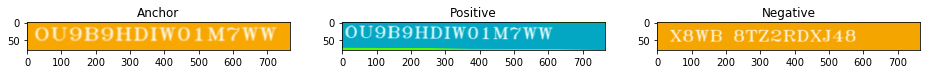

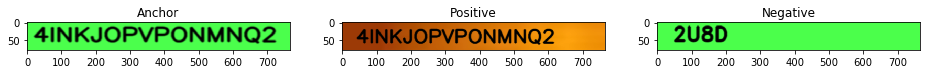

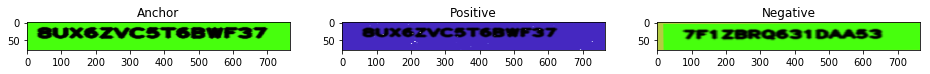

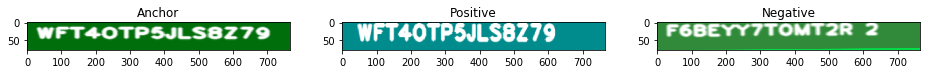

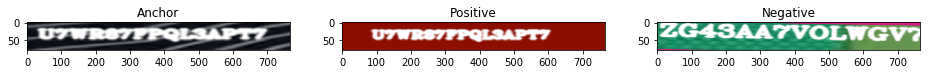

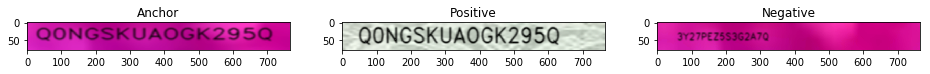

In [13]:
triplets, txtgt = generate_batch_of_triplets(6)
print(triplets[0].shape)
drawTriplets(triplets)